In [63]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA

import tensorflow as tf

from keras.models import Sequential, Model
from keras.layers import Conv1D, MaxPooling1D, Dense, Flatten, Input, AveragePooling1D, Dropout, Softmax
from keras.optimizers import Adam, Nadam
from keras.regularizers import L2
from keras.callbacks import ReduceLROnPlateau, LearningRateScheduler, Callback, LambdaCallback
from keras.metrics import Metric

from time import perf_counter
import functools
import itertools
import sys

In [2]:
stresses = ['Gm', 'Drought', 'Nutrient_Deficiency', 'Fs', 'Salinity']

In [3]:
csv_path = r'..\combined.csv'
df = pd.read_csv(csv_path)
df.drop(columns=['Unnamed: 0'], inplace=True, errors='ignore')
df.drop(columns=['Fungal_infection'], inplace=True, errors='ignore')
df[stresses] = df[stresses].astype(bool)

C:\Users\amitt\AppData\Local\Temp\ipykernel_22560\1297277926.py:2: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(csv_path)


In [4]:
spec_cols = [col for col in df.columns if col[0] == 'X']

In [5]:
trait_cols = df.columns[list(df.columns).index(spec_cols[-1])+1:]

## PCA

In [6]:
df[trait_cols]

,Photo,Ci,Cond,CTleaf,Trmmol,WUEi,WUEin,Fv_Fm,Fv_Fo,PI,...,B_carotene,Glucose,Fructose,Sucrose,Sugars,Starch,Ellagic,Gal,Rut,CTs
0,4.008929,292.743465,0.071230,30.207829,1.762790,4.074427,51.200932,0.773955,2.917367,1.133436,...,180.672913,4.114120,4.321044,2.106877,10.377295,2.430284,215.327766,123.012942,37.911137,16.153354
1,5.130259,283.885987,0.074605,30.403238,1.348682,3.106062,51.933366,0.775109,3.394285,1.129566,...,185.691351,5.253359,4.398900,2.090093,10.430779,1.620732,159.648059,140.224392,34.913800,12.904982
2,8.858282,296.908460,0.140621,29.670082,2.404904,3.727423,43.612878,0.798006,3.860564,1.649234,...,223.876583,5.130809,4.122389,2.148208,9.001072,1.204313,169.093819,137.268720,26.315744,13.429072
3,8.279597,280.256304,0.201223,38.212076,2.855453,2.585259,57.193768,0.780409,3.497533,1.241248,...,134.435161,6.996149,5.455238,1.557863,14.307212,5.177277,98.561955,70.040873,15.097144,13.590456
4,6.057932,308.239776,0.131779,29.129916,1.967089,3.619284,39.203700,0.789944,3.376326,1.177396,...,160.339162,6.490596,3.602786,2.163037,10.592087,1.899691,244.166164,169.102470,40.167820,18.469889
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23651,4.018385,256.221417,0.057586,28.672071,1.147185,4.807882,73.649873,0.778493,3.174867,1.238890,...,50.680347,0.491981,2.142298,2.022112,6.362280,0.064974,229.208398,46.702728,30.452206,2.524192
23652,-0.217584,257.371776,0.004592,28.951705,0.246464,4.087409,63.542544,0.704436,3.015655,0.703920,...,2.102093,3.317779,2.946461,4.029103,8.485325,0.677890,228.950841,102.741536,46.396327,6.360440
23653,1.622401,249.899301,0.070348,29.579215,0.059604,6.017935,72.992996,0.785136,3.432988,1.250422,...,7.064565,1.433723,1.722290,1.883972,5.001576,-2.390555,439.018157,102.577759,34.947248,9.521822
23654,6.476374,241.355991,0.078333,28.634155,1.884827,3.937163,69.527376,0.765940,3.419606,0.997577,...,11.266166,0.839294,2.183542,2.365718,5.722241,0.596050,311.728885,39.374667,34.287740,1.880939


In [7]:
pca = PCA(n_components=10)
x_pca = pca.fit_transform(df[trait_cols].values)

In [8]:
pca.explained_variance_ratio_.cumsum()

array([0.67645515, 0.8515996 , 0.95720411, 0.97574504, 0.98486931,
       0.99101191, 0.99546313, 0.99799683, 0.99894417, 0.99946745])

## NN

In [9]:
x_pca = df[trait_cols].values

x_pca = (x_pca - x_pca.min(axis=0))/(x_pca.max(axis=0)-x_pca.min(axis=0))
y = df[stresses].values

x_train, x_val, y_train, y_val = train_test_split(x_pca, y, test_size=.2)

In [10]:
class Accuracy(Metric):
    def __init__(self, name='accuracy', **kwargs):
        super().__init__(name=name, **kwargs)
        self.accuracy = self.add_variable(
            shape=(),
            initializer='zeros',
            name='accuracy'
        )

    def update_state(self, y_true, y_pred, sample_weight=None):
        p = tf.cast(tf.reduce_all((y_pred > .5) == y_true, axis=1), tf.float32)
        
        self.accuracy.assign(tf.reduce_mean(p))

    def result(self):
        return self.accuracy

In [11]:
model = Sequential([
    Input((x_pca.shape[1],)),
    Dense(256, kernel_regularizer=L2(.00), activation='relu'),
    Dropout(.2),
    Dense(256, kernel_regularizer=L2(.00), activation='relu'),
    Dropout(.2),
    Dense(256, kernel_regularizer=L2(.00), activation='relu'),
    Dropout(.2),
    Dense(256, kernel_regularizer=L2(.00), activation='relu'),
    Dropout(.1),
    Dense(256, kernel_regularizer=L2(.00), activation='relu'),
    Dropout(.1),
    Dense(256, kernel_regularizer=L2(.00), activation='relu'),
    Dropout(.1),
    Dense(y.shape[1], activation='sigmoid'),
])

model.compile(optimizer=Nadam(1e-4), loss='binary_crossentropy', metrics=[Accuracy])

In [12]:
start = perf_counter()

history = model.fit(
    x_train,
    y_train,
    epochs=100,
    validation_data=(x_val, y_val),
    batch_size=80,
)

print(perf_counter() - start)

Epoch 1/100
237/237 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.3752 - loss: 0.5005 - val_accuracy: 0.5000 - val_loss: 0.3434
Epoch 2/100
237/237 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.3972 - loss: 0.3354 - val_accuracy: 0.4167 - val_loss: 0.2793
Epoch 3/100
237/237 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.4136 - loss: 0.2908 - val_accuracy: 0.4167 - val_loss: 0.2569
Epoch 4/100
237/237 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.4356 - loss: 0.2713 - val_accuracy: 0.5000 - val_loss: 0.2455
Epoch 5/100
237/237 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.4486 - loss: 0.2555 - val_accuracy: 0.5000 - val_loss: 0.2324
Epoch 6/100
237/237 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.4622 - loss: 0.2457 - val_accuracy: 0.5833 - val_loss: 0.2215
Epoch 7/100
237/237 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.4735 - loss: 0.2382 - val_accuracy: 0.5833 - val_loss: 0.2162
Epoch 8/100
237/237 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.4860 - loss: 0.2255 - val_accu

In [13]:
y_pred = model.predict(x_val)

(~y_val).mean(), ((y_pred > .5) == y_val).mean()

148/148 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


(0.8377852916314454, 0.9983093829247676)

Text(0.5, 1.0, 'NN Loss over Training')

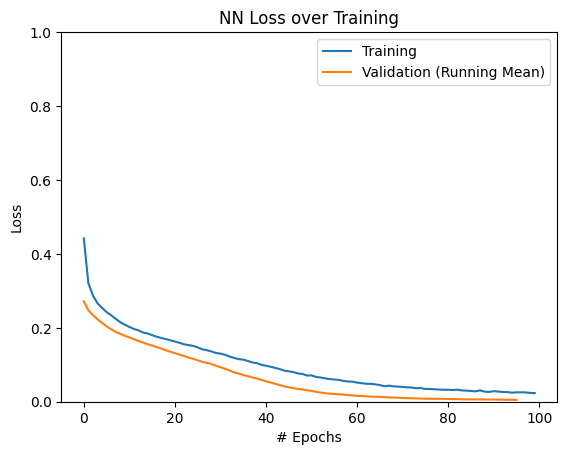

In [14]:
fig = plt.figure()
ax = plt.gca()

ax.plot(history.history['loss'], label='Training')
ax.plot(
    np.convolve(np.array(history.history['val_loss']), np.ones(5)/5, mode='valid'),
    label='Validation (Running Mean)'
)
ax.legend()
ax.set_xlabel('# Epochs')
ax.set_ylabel('Loss')
ax.set_ylim((0, 1))
ax.set_title('NN Loss over Training')

## Interpretation

### Sensitivity

In [15]:
with tf.GradientTape() as tape:
    x = tf.Variable(x_pca)
    outs = model(x)
    grads = tape.gradient(outs, x)
    sensitivity = (grads * x).numpy()
    sensitivity = (sensitivity-sensitivity.min(axis=0))/(sensitivity.max(axis=0)-sensitivity.min(axis=0))

In [16]:
s_z = np.empty((len(stresses), sensitivity.shape[1]))
for i in range(len(stresses)):
    s_i = y[:,i]
    s_z[i] = np.abs(sensitivity[s_i].mean(axis=0) - sensitivity[~s_i].mean(axis=0))/sensitivity[~s_i].std(axis=0)
s_z

array([[0.09114935, 0.35476275, 0.18950305, 0.02001193, 0.21087752,
        0.12261026, 0.35713025, 0.20830421, 0.29425009, 0.07720836,
        0.17949123, 0.15838718, 0.07733011, 0.20564727, 0.26537337,
        0.05939944, 0.21194153, 0.20366524, 0.07447877, 0.05569513,
        0.10467021, 0.16568559, 0.17771217, 0.22106458, 0.04660177,
        0.08750442, 0.2138599 , 0.08536264, 0.32184344, 0.15469478,
        0.1521346 , 0.08519497, 0.18102303, 0.12075527, 0.00749618],
       [0.02076973, 0.12945442, 0.1984366 , 0.17406227, 0.60940503,
        0.38534184, 0.94843363, 0.5412005 , 0.57220366, 0.33593202,
        0.21382868, 0.37095574, 0.1075694 , 0.09924695, 0.76975042,
        0.24495737, 0.26934244, 1.12158321, 0.41130311, 0.28618583,
        0.23498283, 1.25600094, 0.22718096, 0.91545681, 0.40663067,
        0.38650223, 0.75623517, 0.41401014, 0.8538665 , 0.2682518 ,
        0.06692307, 0.31787545, 0.10790839, 0.48199055, 0.1741904 ],
       [0.16627581, 0.24841935, 0.01079341, 0.

### Layer-Wise Relevance Propagation

In [17]:
n_samples = 1000

In [18]:
i_s = np.random.choice(x_pca.shape[0], n_samples, replace=False)
temp_x = x_pca[i_s]
activations = [temp_x]
for layer in model.layers:
    temp_x = layer(temp_x)
    activations.append(temp_x.numpy())

In [19]:
alpha = 3
beta = 2
epsilon = 1e-5

relevances = [activations[-1]]

for i in range(len(activations)-1,0,-1):
    weights = np.ones((activations[i-1].shape[1], activations[i].shape[1]))
    biases = np.zeros((activations[i].shape[1],))
    
    if model.layers[i-1].weights:
        weights = model.layers[i-1].weights[0].numpy()
        biases = model.layers[i-1].weights[1].numpy()

    weights_p = weights * (weights > 0)
    weights_n = weights * (weights < 0)

    pre_activations_p = activations[i-1] @ weights_p
    pre_activations_n = activations[i-1] @ weights_n

    r = np.zeros(activations[i-1].shape)

    for j in range(activations[i-1].shape[1]):        
        r_a = activations[i-1][:,j,np.newaxis] * np.repeat(weights_p[j,np.newaxis],activations[i-1].shape[0],axis=0) / (pre_activations_p + epsilon)
        r_b = activations[i-1][:,j,np.newaxis] * np.repeat(weights_n[j,np.newaxis],activations[i-1].shape[0],axis=0) / (pre_activations_n + epsilon)

        r[:,j] = ((alpha * r_a - beta * r_b) * relevances[-1]).sum(axis=1)
    relevances.append(r)

    print(i)

relevances = relevances[::-1]

13
12
11
10
9
8
7
6
5
4
3
2
1


In [20]:
input_relevances = relevances[0] / relevances[0].max()

In [21]:
n_stressed_samples = 6
assert n_stressed_samples < n_samples

i_stressed = np.random.choice(np.arange(i_s.shape[0])[y[i_s].any(axis=1)], n_stressed_samples, replace=False)
i_s_stressed = i_s[i_stressed]

In [22]:
y[i_s_stressed]

array([[False, False,  True, False,  True],
       [False, False,  True, False, False],
       [False, False,  True, False,  True],
       [ True, False, False, False, False],
       [ True, False, False,  True, False],
       [ True, False, False, False, False]])

Text(0.5, 0.98, 'Layer-wise Relevance Propagation ($\\alpha$=3, $\\beta$=2)')

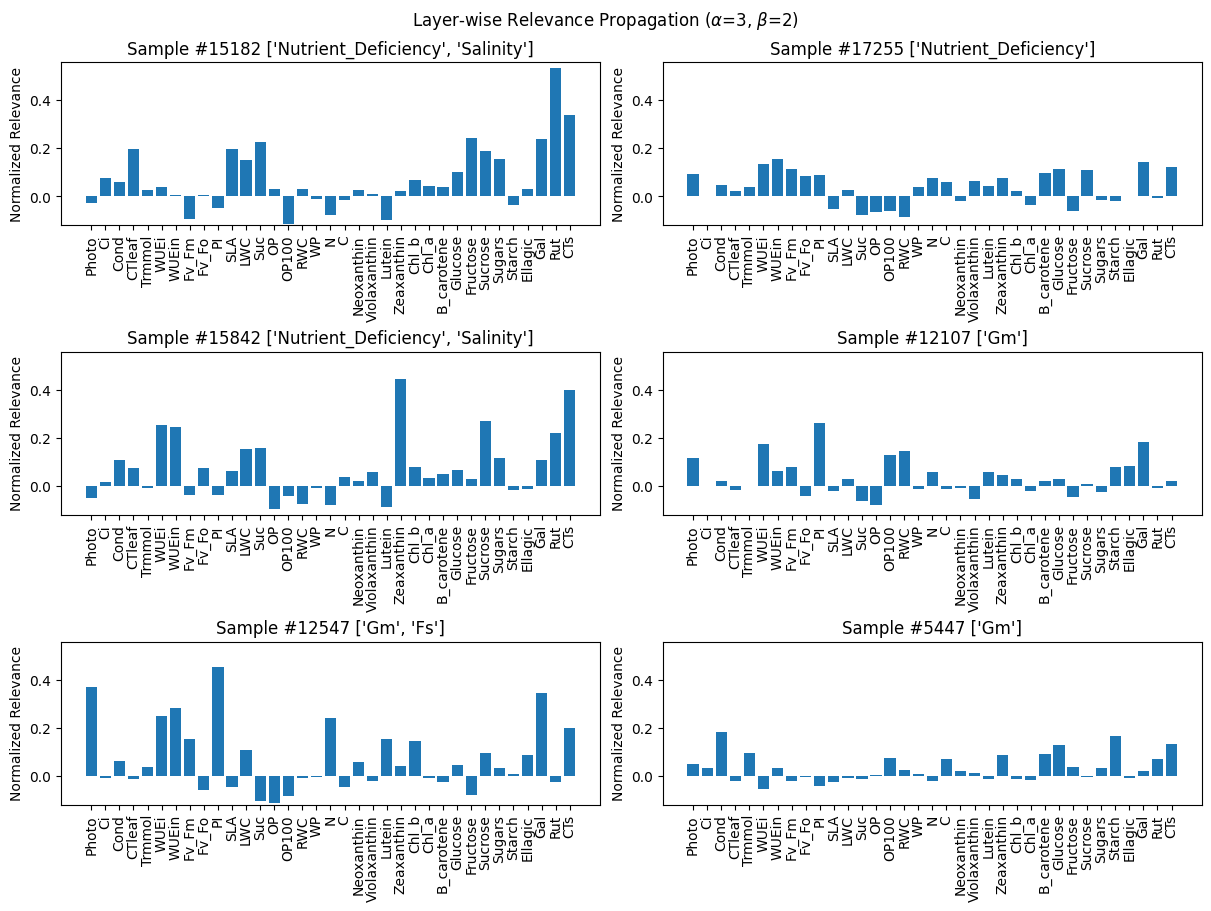

In [23]:
fig, axs = plt.subplots(3, 2, constrained_layout=True, figsize=(12,9))
axs = list(itertools.chain.from_iterable(axs))
x_h = np.arange(input_relevances.shape[1])

ax_min, ax_max = input_relevances[i_stressed].min() * 1.05,input_relevances[i_stressed].max() * 1.05

for i, ax in enumerate(axs):
    ax.bar(x_h, input_relevances[i_stressed[i]])
    ax.set_xticks(x_h, labels=trait_cols, rotation=90)
    ax.set_title(
        f'Sample #{i_s_stressed[i]} {[stresses[j] for j in range(len(stresses)) if y[i_s_stressed[i]][j]]}'
    )
    ax.set_ylabel('Normalized Relevance')
    ax.set_ylim((ax_min, ax_max))

fig.suptitle(f'Layer-wise Relevance Propagation ($\\alpha$={alpha}, $\\beta$={beta})')

In [45]:
z_diff = np.empty((len(stresses), len(trait_cols)))

for i in range(z_diff.shape[0]):
    input_r_p = input_relevances[np.arange(i_s.shape[0])[y[i_s,i]]]
    input_r_n = input_relevances[np.arange(i_s.shape[0])[~y[i_s,i]]]
    z_diff[i] = (input_r_p.mean(axis=0) - input_r_n.mean(axis=0)) / input_r_n.std(axis=0)

In [61]:
z_diff_traits = {}
for i in range(z_diff.shape[0]):
    z_diff_traits[stresses[i]] = list(trait_cols[z_diff[i] > 2])

In [62]:
z_diff_traits

{'Gm': ['N'],
 'Drought': ['Fv_Fm', 'Neoxanthin', 'Violaxanthin', 'Lutein', 'Chl_a', 'Gal'],
 'Nutrient_Deficiency': [],
 'Fs': ['PI', 'N'],
 'Salinity': ['CTleaf', 'Rut']}

In [75]:
# lrp_df = pd.DataFrame(input_relevances, index=i_s, columns=trait_cols)
# lrp_df[stresses] = df.loc[i_s, stresses]
# lrp_df.to_csv(f'lrp_a{alpha}_b{beta}.csv')